# Fraud Detection — End-to-End Model Development Notebook

This notebook is a **developer scratchpad** that covers the full model development lifecycle **before modularizing** into `training/` and `inference/`.

It follows the project contract:
- **Use case:** Credit card fraud detection (binary classification, imbalanced)
- **Model:** Logistic Regression (`class_weight="balanced"`)
- **Primary metric:** ROC-AUC
- **Guardrail:** Precision @ Recall ≥ 0.80
- **Artifacts:** model + metrics JSON

> **Expected dataset path:** `data/raw/creditcard.csv` (Kaggle “Credit Card Fraud Detection” dataset)


In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.1 MB 6.3 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 9.2 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.1 MB 9.4 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.5 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ----------------------------------- ---- 2.1/2.3 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 10.2 MB/s  0:00:00
Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl (7.0 MB)
Using cached py

In [5]:
# 0) Setup: imports + config
import os
import json
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    classification_report,
    confusion_matrix,
)

RANDOM_SEED = 42
RAW_CSV_PATH = "../data/raw/creditcard.csv"
TARGET_COL = "Class"

# Guardrail contract
MIN_RECALL_GUARDRAIL = 0.80

# Promotion policy (for notebook demo vs baseline)
MIN_AUC_IMPROVEMENT = 0.015  # 1.5% absolute AUC improvement

# Artifact outputs (notebook-friendly)
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

CANDIDATE_MODEL_PATH = os.path.join(ARTIFACT_DIR, "candidate_model.joblib")
CANDIDATE_METRICS_PATH = os.path.join(ARTIFACT_DIR, "candidate_metrics.json")

# Optional baseline metrics for local gating demo (not required)
BASELINE_METRICS_PATH = os.path.join(ARTIFACT_DIR, "baseline_metrics.json")

print("Config:")
print(" RAW_CSV_PATH:", RAW_CSV_PATH)
print(" TARGET_COL:", TARGET_COL)
print(" MIN_RECALL_GUARDRAIL:", MIN_RECALL_GUARDRAIL)


Config:
 RAW_CSV_PATH: ../data/raw/creditcard.csv
 TARGET_COL: Class
 MIN_RECALL_GUARDRAIL: 0.8


## 1) Load data + basic sanity checks

If you don't have the dataset yet, download it and place it here:

```
data/raw/creditcard.csv
```

The target column is expected to be `Class` where:
- `1 = fraud`
- `0 = legitimate`


In [6]:
# 1) Load data
df = pd.read_csv(RAW_CSV_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

assert TARGET_COL in df.columns, f"Target column '{TARGET_COL}' not found!"

# Sanity checks
print("\nMissing values per column (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

fraud_rate = df[TARGET_COL].mean()
print(f"\nFraud rate: {fraud_rate:.6f} ({fraud_rate*100:.4f}%)")
print(df[TARGET_COL].value_counts())


Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing values per column (top 10):
Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
dtype: int64

Fraud rate: 0.001727 (0.1727%)
Class
0    284315
1       492
Name: count, dtype: int64


In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2) Quick EDA graphs (imbalance + feature sanity)

These plots help confirm:
- class imbalance is extreme (as expected)
- `Amount` distribution is reasonable
- rough separation signals exist (optional)


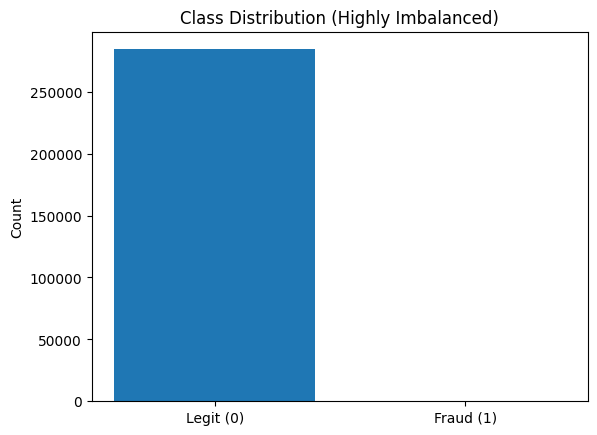

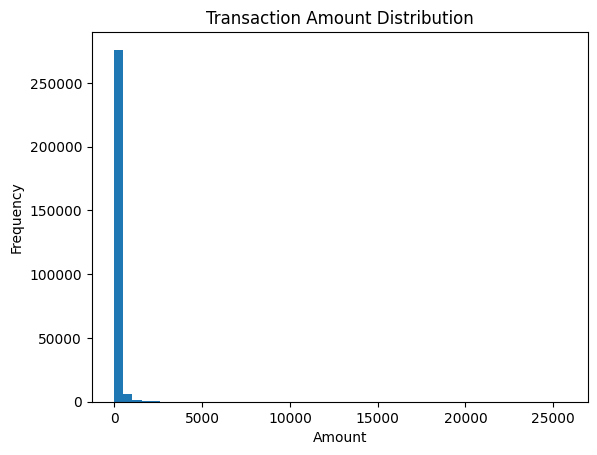

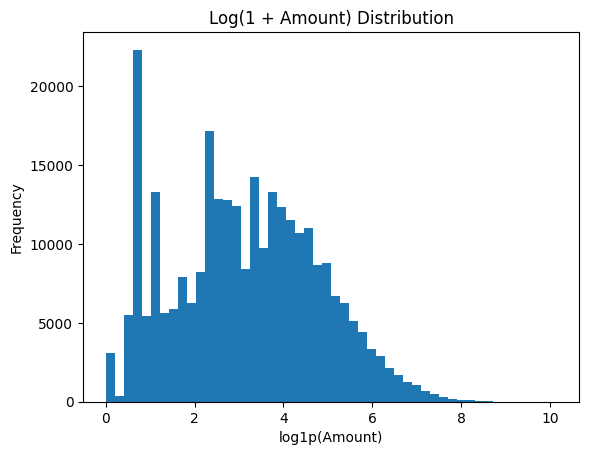

In [8]:
# 2a) Class distribution plot
counts = df[TARGET_COL].value_counts().sort_index()
plt.figure()
plt.bar(["Legit (0)", "Fraud (1)"], [counts.get(0, 0), counts.get(1, 0)])
plt.title("Class Distribution (Highly Imbalanced)")
plt.ylabel("Count")
plt.show()

# 2b) Amount distribution (log scale helps)
plt.figure()
plt.hist(df["Amount"], bins=50)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

plt.figure()
plt.hist(np.log1p(df["Amount"]), bins=50)
plt.title("Log(1 + Amount) Distribution")
plt.xlabel("log1p(Amount)")
plt.ylabel("Frequency")
plt.show()


## 3) Train / Validation / Test split (stratified)

Because fraud is rare, we **must** stratify by target.  
We use a 70/15/15 split.

- Promotion decisions should be based on **validation** only
- Final reporting uses **test** only


In [9]:
# 3) Stratified split: 70/15/15
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=RANDOM_SEED
)

print("Split sizes:")
print(" Train:", X_train.shape, "Fraud rate:", y_train.mean())
print(" Val:  ", X_val.shape, "Fraud rate:", y_val.mean())
print(" Test: ", X_test.shape, "Fraud rate:", y_test.mean())


Split sizes:
 Train: (199364, 30) Fraud rate: 0.0017254870488152324
 Val:   (42721, 30) Fraud rate: 0.0017321691907960957
 Test:  (42722, 30) Fraud rate: 0.0017321286456626562


## 4) Helper functions (guardrail + thresholding)

Guardrail metric:
- **Precision @ Recall ≥ MIN_RECALL_GUARDRAIL**

We also compute a threshold that meets the recall constraint and maximizes precision under that constraint.


In [10]:
def precision_at_min_recall(y_true: np.ndarray, y_proba: np.ndarray, min_recall: float) -> float:
    """Best precision achievable with recall >= min_recall by sweeping thresholds."""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    mask = recall >= min_recall
    if not np.any(mask):
        return 0.0
    return float(np.max(precision[mask]))


def threshold_for_min_recall(y_true: np.ndarray, y_proba: np.ndarray, min_recall: float) -> float:
    """Threshold that achieves recall >= min_recall and maximizes precision among eligible thresholds."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    # Align precision/recall with thresholds (drop the last point)
    precision = precision[:-1]
    recall = recall[:-1]

    mask = recall >= min_recall
    if not np.any(mask):
        return 1.0  # never predict fraud
    best_idx = np.argmax(precision[mask])
    eligible_thresholds = thresholds[mask]
    return float(eligible_thresholds[best_idx])


print("Helpers ready.")


Helpers ready.


## 5) Train baseline model (Logistic Regression)

This is intentionally “boring but strong”:
- Fast to train (CI-friendly)
- Interpretable
- Great baseline for probability-based thresholding
- Handles imbalance via `class_weight="balanced"`


In [11]:
# 5) Train model
model = LogisticRegression(
    max_iter=2000,
    solver="liblinear",
    class_weight="balanced",
    random_state=RANDOM_SEED,
)
model.fit(X_train, y_train)

val_proba = model.predict_proba(X_val)[:, 1]
test_proba = model.predict_proba(X_test)[:, 1]

# Core metrics
val_roc_auc = roc_auc_score(y_val, val_proba)
test_roc_auc = roc_auc_score(y_test, test_proba)

val_pr_auc = average_precision_score(y_val, val_proba)
test_pr_auc = average_precision_score(y_test, test_proba)

val_p_at_r = precision_at_min_recall(y_val.to_numpy(), val_proba, MIN_RECALL_GUARDRAIL)
test_p_at_r = precision_at_min_recall(y_test.to_numpy(), test_proba, MIN_RECALL_GUARDRAIL)

print("=== Validation ===")
print(" ROC-AUC:", val_roc_auc)
print(" PR-AUC: ", val_pr_auc)
print(f" Precision@Recall≥{MIN_RECALL_GUARDRAIL}:", val_p_at_r)

print("\n=== Test ===")
print(" ROC-AUC:", test_roc_auc)
print(" PR-AUC: ", test_pr_auc)
print(f" Precision@Recall≥{MIN_RECALL_GUARDRAIL}:", test_p_at_r)


=== Validation ===
 ROC-AUC: 0.9682289682934511
 PR-AUC:  0.6274370689695334
 Precision@Recall≥0.8: 0.5504587155963303

=== Test ===
 ROC-AUC: 0.9676823348390597
 PR-AUC:  0.7910805155266587
 Precision@Recall≥0.8: 0.9090909090909091


## 6) ROC curve + Precision-Recall curve (graphs)

These plots are standard in imbalanced classification:
- ROC curve: ranking quality
- PR curve: performance on minority class (fraud) is clearer here


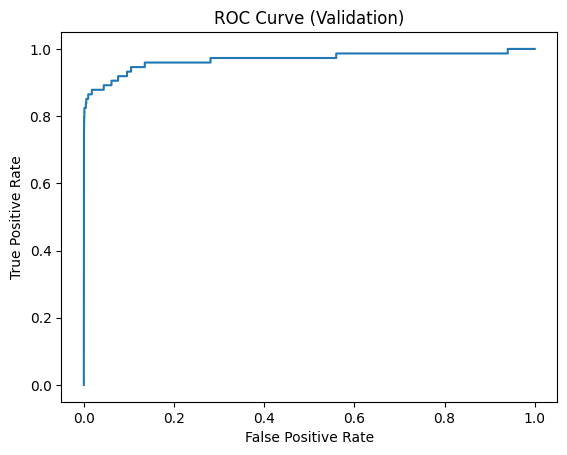

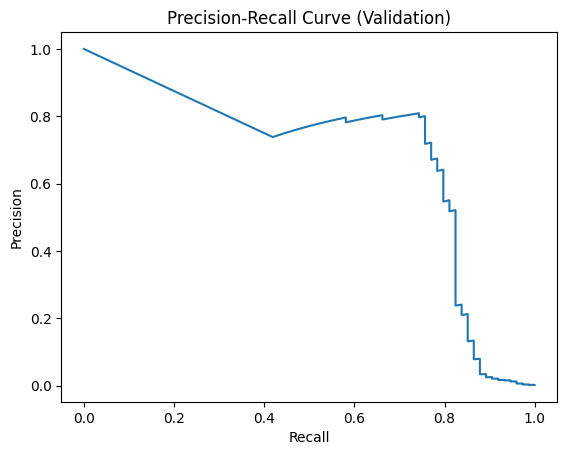

Validation ROC-AUC: 0.9682289682934511
Validation PR-AUC: 0.6274370689695334


In [12]:
# 6a) ROC curve (validation)
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve (Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# 6b) Precision-Recall curve (validation)
precision, recall, _ = precision_recall_curve(y_val, val_proba)
plt.figure()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve (Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("Validation ROC-AUC:", val_roc_auc)
print("Validation PR-AUC:", val_pr_auc)


## 7) Choose threshold to satisfy guardrail + inspect confusion matrix

We choose a threshold that meets:
- Recall ≥ MIN_RECALL_GUARDRAIL
and among those thresholds, maximize precision.

This emulates real fraud workflows: “catch at least X% of fraud, then reduce false alarms.”


In [13]:
best_threshold = threshold_for_min_recall(y_val.to_numpy(), val_proba, MIN_RECALL_GUARDRAIL)
print(f"Chosen threshold for Recall≥{MIN_RECALL_GUARDRAIL}: {best_threshold:.6f}")

val_pred = (val_proba >= best_threshold).astype(int)
test_pred = (test_proba >= best_threshold).astype(int)

print("\nConfusion Matrix (VAL):")
print(confusion_matrix(y_val, val_pred))
print("\nClassification Report (VAL):")
print(classification_report(y_val, val_pred, digits=4))

print("\nConfusion Matrix (TEST):")
print(confusion_matrix(y_test, test_pred))
print("\nClassification Report (TEST):")
print(classification_report(y_test, test_pred, digits=4))


Chosen threshold for Recall≥0.8: 0.987384

Confusion Matrix (VAL):
[[42598    49]
 [   14    60]]

Classification Report (VAL):
              precision    recall  f1-score   support

           0     0.9997    0.9989    0.9993     42647
           1     0.5505    0.8108    0.6557        74

    accuracy                         0.9985     42721
   macro avg     0.7751    0.9048    0.8275     42721
weighted avg     0.9989    0.9985    0.9987     42721


Confusion Matrix (TEST):
[[42618    30]
 [   13    61]]

Classification Report (TEST):
              precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     42648
           1     0.6703    0.8243    0.7394        74

    accuracy                         0.9990     42722
   macro avg     0.8350    0.9118    0.8694     42722
weighted avg     0.9991    0.9990    0.9990     42722



## 8) Save candidate artifacts (model + metrics JSON)

This mirrors what the modular pipeline does later:
- model saved as `artifacts/candidate_model.joblib`
- metrics saved as `artifacts/candidate_metrics.json`


In [14]:
metrics = {
    "dataset": "creditcardfraud",
    "target": TARGET_COL,
    "model_type": "LogisticRegression(class_weight=balanced)",
    "split": {"train": 0.70, "val": 0.15, "test": 0.15},
    "guardrail": {"min_recall": MIN_RECALL_GUARDRAIL},
    "threshold": {"chosen_for_min_recall": float(best_threshold)},
    "val": {
        "roc_auc": float(val_roc_auc),
        "pr_auc": float(val_pr_auc),
        "precision_at_min_recall": float(val_p_at_r),
        "fraud_rate": float(y_val.mean()),
    },
    "test": {
        "roc_auc": float(test_roc_auc),
        "pr_auc": float(test_pr_auc),
        "precision_at_min_recall": float(test_p_at_r),
        "fraud_rate": float(y_test.mean()),
    },
    "created_at": datetime.now(timezone.utc).isoformat(),
}

joblib.dump(model, CANDIDATE_MODEL_PATH)
with open(CANDIDATE_METRICS_PATH, "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved candidate model to:", CANDIDATE_MODEL_PATH)
print("✅ Saved candidate metrics to:", CANDIDATE_METRICS_PATH)


✅ Saved candidate model to: artifacts\candidate_model.joblib
✅ Saved candidate metrics to: artifacts\candidate_metrics.json


## 9) Optional: Notebook promotion gate vs a stored baseline

This is a light simulation of the CI gate:
- If no baseline exists, we bootstrap it.
- Otherwise, we compare AUC improvement and guardrail non-regression.


In [15]:
def load_json(path: str):
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

baseline = load_json(BASELINE_METRICS_PATH)

if baseline is None:
    print("No baseline found. Bootstrapping baseline_metrics.json for future runs.")
    with open(BASELINE_METRICS_PATH, "w", encoding="utf-8") as f:
        json.dump(
            {
                "val_roc_auc": float(val_roc_auc),
                "val_precision_at_min_recall": float(val_p_at_r),
                "min_recall_guardrail": MIN_RECALL_GUARDRAIL,
                "created_at": datetime.now(timezone.utc).isoformat(),
            },
            f,
            indent=2,
        )
    print("✅ Saved baseline metrics to:", BASELINE_METRICS_PATH)
else:
    prod_auc = float(baseline["val_roc_auc"])
    prod_p_at_r = float(baseline["val_precision_at_min_recall"])

    auc_improvement = val_roc_auc - prod_auc
    guardrail_ok = val_p_at_r >= prod_p_at_r
    passed = (auc_improvement >= MIN_AUC_IMPROVEMENT) and guardrail_ok

    print("=== Promotion Gate (Notebook Demo) ===")
    print(" Production ROC-AUC:", prod_auc)
    print(" Candidate  ROC-AUC:", val_roc_auc)
    print(" Δ ROC-AUC:", auc_improvement, f"(min required: {MIN_AUC_IMPROVEMENT})")
    print(" Production Precision@Recall:", prod_p_at_r)
    print(" Candidate  Precision@Recall:", val_p_at_r)
    print(" Guardrail non-regression:", guardrail_ok)
    print(" RESULT:", "PASS ✅" if passed else "FAIL ❌")


No baseline found. Bootstrapping baseline_metrics.json for future runs.
✅ Saved baseline metrics to: artifacts\baseline_metrics.json
